# Kv 1.4 + 2.1 parameter extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
write = True
paint = True
filebase = '/home/kernfel/Documents/Data/Oocytes/2017_12_12_%04d.atf'
fileno, fileno2, fileno3, targetno = 18,19,None,20
savebase = filebase[:-4] % fileno + '-' + str(fileno3 or fileno2)
paramsfile = filebase[:-4] % targetno + '.params'
params = dict()
tres = 0.025 # Time of one sample in ms

In [3]:
rec = read_2channel_ATF(filebase % fileno)
rec2 = read_2channel_ATF(filebase % fileno2)
rec3 = read_2channel_ATF(filebase % fileno3) if fileno3 else None

## Sanity checks

To make sure we've got the right recordings, let's visualise the full trace stacks:

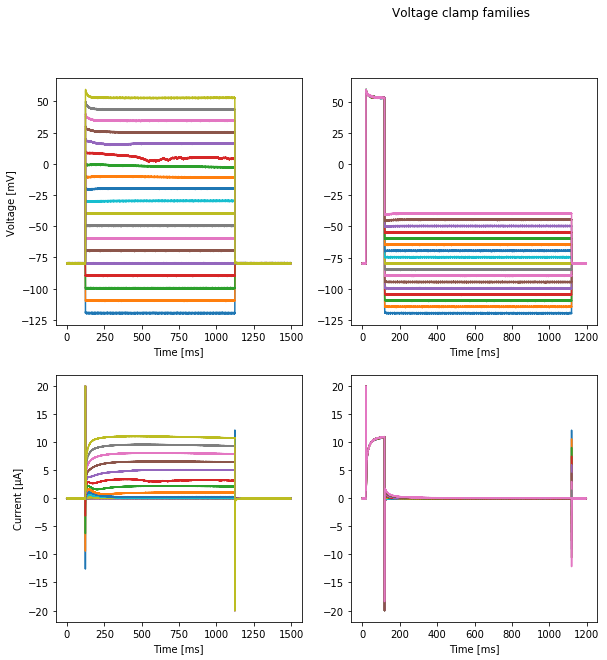

In [4]:
t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres
t3 = np.arange(len(rec3.voltage[0])) * tres if rec3 else None

def rawplot(ax, T, Y, ylabel=''):
    for y in Y:
        plt.plot(T, y)
    plt.xlabel('Time [ms]')
    plt.ylabel(ylabel)

if paint:
    fig = plt.figure(figsize=(15,10))
    fig.suptitle('Voltage clamp families')

    rawplot(plt.subplot(2,3,1), t, rec.voltage, 'Voltage [mV]')
    rawplot(plt.subplot(2,3,2), t2, rec2.voltage)
    if rec3: rawplot(plt.subplot(2,3,3), t3, rec3.voltage)

    rawplot(plt.subplot(2,3,4), t, rec.current, u'Current [μA]')
    rawplot(plt.subplot(2,3,5), t2, rec2.current)
    if rec3: rawplot(plt.subplot(2,3,6), t3, rec3.current)

    if write:
        fig.savefig(savebase + '.family.png')

Let's sanity check the step boundaries. The vertical lines should mark the exact beginning of the step and at least the end of the capacitive spike. Should the latter not coincide, the limits needs to be adjusted!

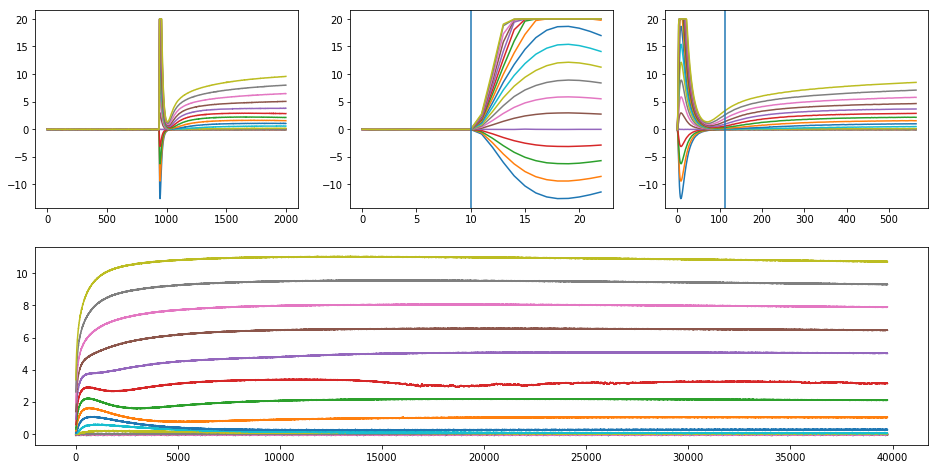

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5050, 44800)

# The true step time
rec_step_t0 = 4937

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec.current:
        plt.plot(I[4000:6000])

    plt.subplot(2,3,2)
    for I in rec.current:
        plt.plot(I[4927:4950])
    plt.axvline(rec_step_t0 - 4927)

    plt.subplot(2,3,3)
    for I in rec.current:
        plt.plot(I[rec_step_t0:rec_step_t0 + 5*(rec_limits[0]-rec_step_t0)])
    plt.axvline(rec_limits[0] - rec_step_t0)

    plt.subplot(2,1,2)
    for I in rec.current:
        plt.plot(I[rec_limits[0]:rec_limits[1]])

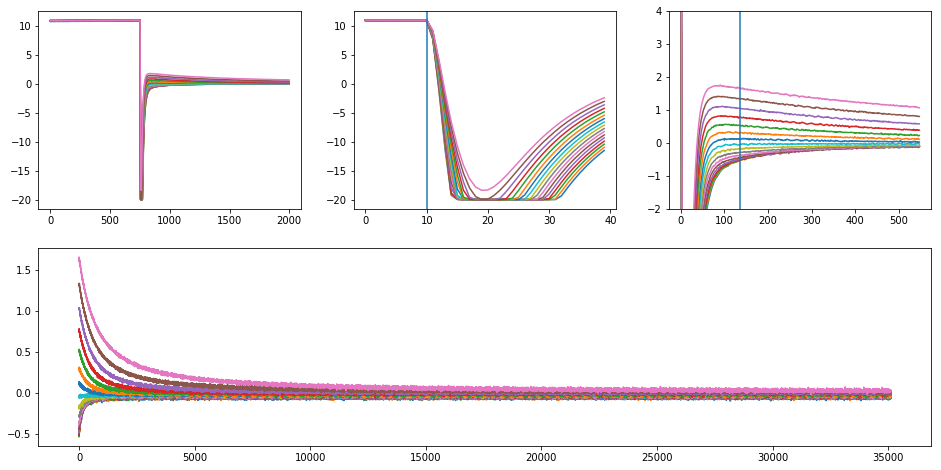

In [6]:
# The start and end of the step -- here, the first number is the true step time
rec2_limits = (4750, 40000)

# The cutoff for the tail current as used in the tail fitting procedure; this should mark the end of the capacitive spike
rec2_cut, dummy = get_tail_cut(rec2, rec2_limits[0])

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec2.current:
        plt.plot(I[4000:6000])

    plt.subplot(2,3,2)
    for I in rec2.current:
        plt.plot(I[4740:4780])
    plt.axvline(rec2_limits[0] - 4740)

    plt.subplot(2,3,3)
    for I in rec2.current:
        plt.plot(I[rec2_limits[0]:rec2_limits[0] + 4*(rec2_cut-rec2_limits[0])])
    plt.axvline(rec2_cut-rec2_limits[0])
    plt.ylim(-2,4)

    plt.subplot(2,1,2)
    for I in rec2.current:
        plt.plot(I[rec2_cut:rec2_limits[1]])

Finally, a sanity check for the third (capacitance) recording, showing a step down and the subsequent step up:

In [7]:
# Index of the first step
rec3_offset = 322

# Step spec
rec3_stepdur = 2000
rec3_nsteps = 9

if rec3 and paint:
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    for V in rec3.voltage:
        plt.plot(t3[300:350], V[300:350])
        plt.plot(t3[300:350], V[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,2)
    for I in rec3.current:
        plt.plot(t3[300:350], I[300:350])
        plt.plot(t3[300:350], I[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,3)
    for V in rec3.voltage:
        plt.plot(V[rec3_offset:rec3_offset+rec3_stepdur])
        plt.plot(V[rec3_offset + (rec3_nsteps-1)*rec3_stepdur:rec3_offset + rec3_nsteps*rec3_stepdur])

## Measurements

### Leak current

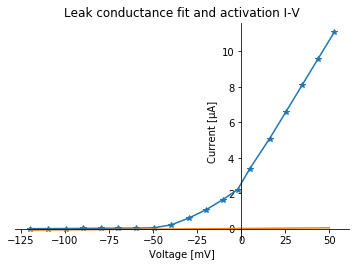

In [8]:
if paint:
    fig, ax = plt.subplots()
else:
    ax = None

fit_leak(rec, params, ax, rec_limits)

if paint:
    plt.title('Leak conductance fit and activation I-V')
    if write:
        plt.savefig(savebase + '.leak_IV.png')

## $E_K$

analysis_helpers.py:100: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:100: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


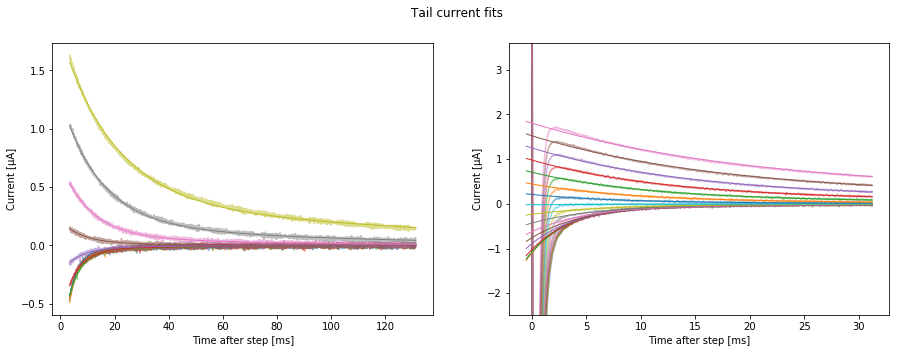

In [9]:
tail_V = [np.median(V[rec2_limits[0]:rec2_limits[1]]) for V in rec2.voltage]

fit_tails_exp2(rec2, rec2_limits[0], rec2_limits[1], baseline = params['I_leak'](tail_V))

if paint:
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plot_tail_fit_exp2(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

    plt.subplot(1,2,2)
    plot_tail_fit_exp2(rec2, params, rec2_limits[0] - 20, 6000, tres, range(0, len(rec2.tails), 1))

    fig.suptitle('Tail current fits')
    if write:
        fig.savefig(savebase + '.tail_fits.png')

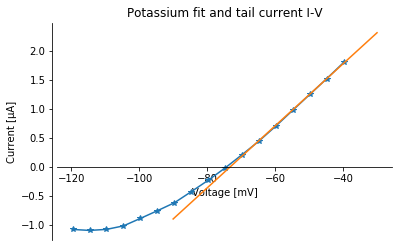

In [10]:
tail_t0 = [exp2_decay(0, rec2.pdecay[i]) for i in range(len(rec2.tails))]

included = linear_exclude_outliers(rec2.tail_voltages, tail_t0)
tail_I = np.array(tail_t0)[included]
tail_V = np.array(rec2.tail_voltages)[included]

# Fit to the positive current values only
for i in range(len(tail_I)-1, 0, -1):
    if tail_I[i] < 0:
        tail_fit_from = i+1
        break

fit_IV(tail_I[tail_fit_from:], tail_V[tail_fit_from:], params, 'K')

if paint:
    fig, ax = plt.subplots()
    IVplot(tail_I, tail_V, ax)

    tail_plot_V = np.array([-90, -30])
    ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

    ax.set_title('Potassium fit and tail current I-V')
    if write:
        plt.savefig(savebase + '.tail_IV.png')

## Current separation
To analyse the two potassium currents separately, I need to
1. find the two peaks corresponding to the fast 1.4 and the slow 2.1 current, and
2. subtract the respective other current from those peaks.
This *could* be done by fitting the full Hodgkin-Huxley model to the traces, but I'm not interested in pin-point accuracy; I'd rather have a reasonable estimate. Therefore, I'm using an estimate of the fraction of peak current at the respective other peak's time, as fitted (*roughly*!) at the end of the Kv14 and Kv21 notebooks.

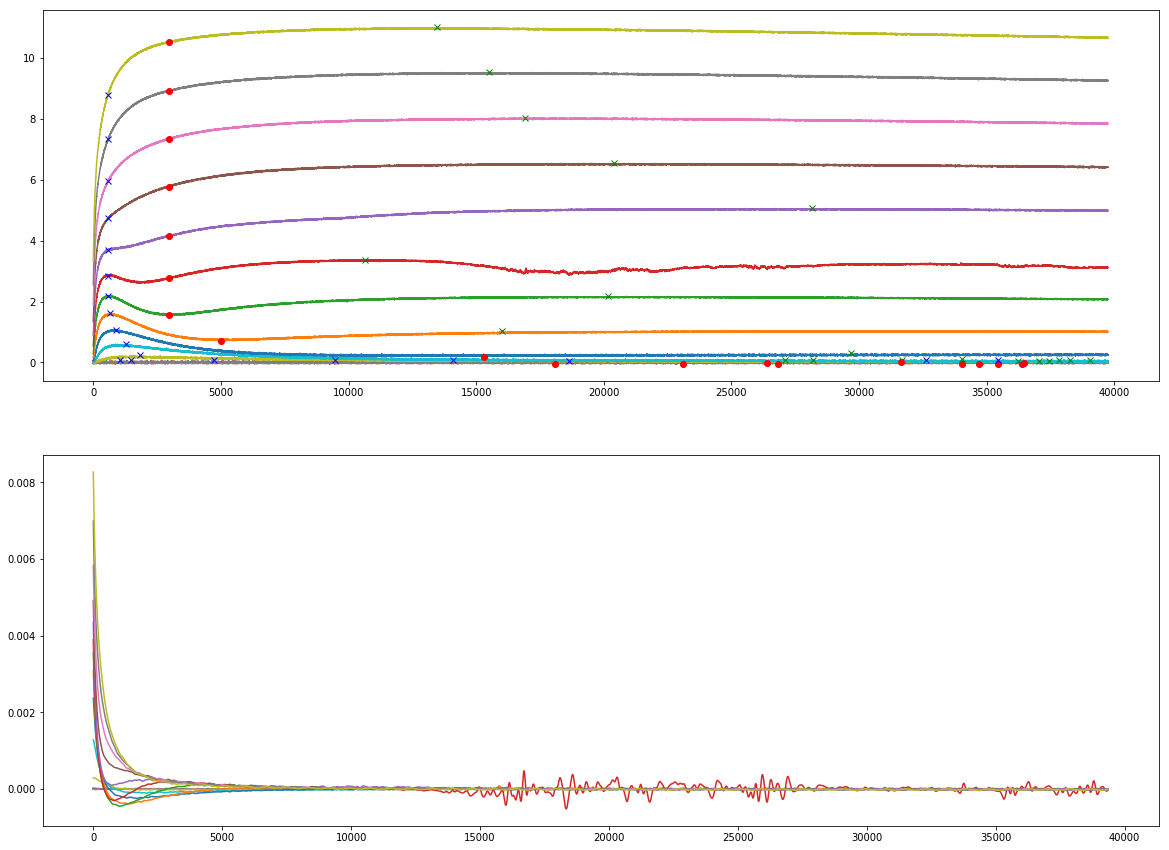

In [11]:
# Finding the two peaks
plt.figure(figsize=(20,15))
ax1 = plt.subplot(3,1,1)

width = 200
w = np.hamming(width)
for i,I in enumerate(rec.current):
    plt.plot(I[rec_limits[0]:rec_limits[1]])

smoothed = [np.convolve(w/w.sum(), I[rec_limits[0]:rec_limits[1]], mode='same') for I in rec.current]

plt.subplot(3,1,2)
t1 = [None] * len(smoothed)
t2 = [None] * len(smoothed)
peak1 = [None] * len(smoothed)
peak2 = [None] * len(smoothed)
for i,I in enumerate(smoothed):
    dI = np.diff(I)
    sdI = np.convolve(w/w.sum(), dI, mode='same')
    plt.plot(sdI[width:-width])
    
    turn1 = np.argmin(sdI[width:-width]) + width
    if i > 11 and turn1 > 5000: # Kv14 too small to evoke a proper peak & trough
        t1[i] = t1[i-1]
        t2[i] = np.argmax(rec.current[i][t1[i]:rec_limits[1]]) + t1[i]
    else:
        turn2 = np.argmax(sdI[turn1:-width]) + turn1
        trough = np.argmin(rec.current[i][turn1+rec_limits[0]:turn2+rec_limits[0]]) + turn1 + rec_limits[0]

        t1[i] = np.argmax(rec.current[i][rec_limits[0]:trough]) + rec_limits[0]
        t2[i] = np.argmax(rec.current[i][trough:rec_limits[1]]) + trough
    
    peak1[i] = rec.current[i][t1[i]]
    peak2[i] = rec.current[i][t2[i]]
    
    ax1.plot(trough-rec_limits[0], rec.current[i][trough], 'ro')
    ax1.plot(t1[i]-rec_limits[0], peak1[i], 'bx')
    ax1.plot(t2[i]-rec_limits[0], peak2[i], 'gx')

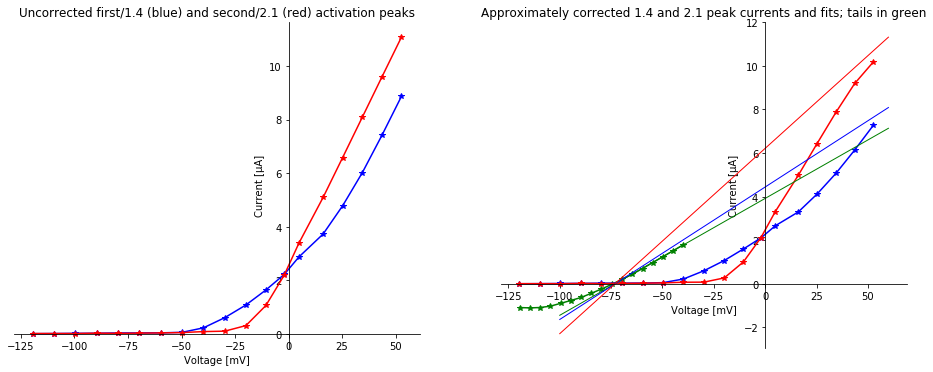

In [12]:
plt.figure(figsize=(16,6))

ax = plt.subplot(1,2,1)
ax.set_title('Uncorrected first/1.4 (blue) and second/2.1 (red) activation peaks')
med_volt = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
IVplot(peak1, med_volt, ax, 'b*-')
IVplot(peak2, med_volt, ax, 'r*-')


# From Kv14 and Kv21 notebooks, using data from 2017_12_06_36-37 (1.4) and 2018_05_03_19-21 (2.1)
f14 = lambda V: 0.000278 * np.exp(0.109829 * V) + 0.030208 # approximate fraction of 1.4 current at the 2.1 peak
f21 = lambda V: 0.001922 * V + 0.053666

I_21 = [(p2 - f14(V)*p1) / (1 - f14(V)*f21(V)) for p1,p2,V in zip(peak1, peak2, med_volt)]
I_14 = [(p1 - f21(V)*p2) / (1 - f21(V)*f14(V)) for p1,p2,V in zip(peak1, peak2, med_volt)]

ax = plt.subplot(1,2,2)
ax.set_title('Approximately corrected 1.4 and 2.1 peak currents and fits; tails in green')
IVplot(tail_I, tail_V, ax, 'g*-')
IVplot(I_14, med_volt, ax, 'b*-')
IVplot(I_21, med_volt, ax, 'r*-')


Vplot = np.array([-100,60])
plt.plot(Vplot, params['I_K'](Vplot), 'g-', linewidth = 1)

fit_IV([0, I_14[-1]*1.05], [params['E_K'], med_volt[-1]], params, 'Kv14')
fit_IV([0, I_21[-1]*1.05], [params['E_K'], med_volt[-1]], params, 'Kv21')

plt.plot(Vplot, params['I_Kv14'](Vplot), 'b-', linewidth=1)
plt.plot(Vplot, params['I_Kv21'](Vplot), 'r-', linewidth=1);

if paint and write:
    plt.savefig(savebase + '.gK.png')

### Capacitance

In [13]:
if rec3: params['C'] = fit_capacitance(rec3, tres, rec3_offset, rec3_stepdur, rec3_nsteps)

In [14]:
# RTDO accounts in mV, nA, μS and is not unit-aware
params_rtdo = params.copy()
params_rtdo['g_leak'] *= 1e3
params_rtdo['g_Kv14'] *= 1e3
params_rtdo['g_Kv21'] *= 1e3

pstr = '\
gl:\t%(g_leak)f μS\n\
El:\t%(E_leak)f mV\n\
gA:\t%(g_Kv14)f μS\n\
gK:\t%(g_Kv21)f μS\n\
EK:\t%(E_K)f mV' % params_rtdo

if rec3: pstr += '\nC:\t%(C)f nF' % params_rtdo

print pstr

if write:
    f = open(paramsfile, 'w')
    f.write(pstr)
    f.close()

gl:	0.764957 μS
El:	-22.926613 mV
gA:	61.870720 μS
gK:	85.798216 μS
EK:	-73.136814 mV
C:	173.626814 nF
